# **Optimal Airline Route Planning and Fleet Utilization under Economic and Infrastructure Constraints in Africa**
### **Numerical Optimization Project With Python**
### **23-01-2025**


# **Import libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import folium
from folium.plugins import MarkerCluster
import pulp
import warnings

warnings.filterwarnings('ignore')

# **Import data and preprocessing**

## ***Airports data***

In [ ]:
# airports  column names: source: https://openflights.org/data.php
airports_columns = [ "airport_id", "name", "city", "country", "iata", "icao", "latitude", "longitude", "altitude", "timezone", "dst", "tz_database", "type", "source"]

In [ ]:
## upload openflight airports
airports = pd.read_csv(
    "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
    header=None,
    names=airports_columns
)

In [ ]:
airports.head()

,airport_id,name,city,country,iata,icao,latitude,longitude,altitude,timezone,dst,tz_database,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


## ***Routes data***

In [ ]:
# routes columns
routes_columns = [
    "airline", "airline_id",
    "source_airport", "source_airport_id",
    "destination_airport", "destination_airport_id",
    "codeshare", "stops", "equipment"
]

In [ ]:
## routes openflights data
routes = pd.read_csv(
    "https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
    header=None,
    names=routes_columns
)

In [ ]:
# print the 5th rows of routes
routes.head(5)

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


# **Data enrichment**

### ***Upload Aircraft***

In [ ]:
air_craft_data = pd.read_excel("https://www.faa.gov/airports/engineering/aircraft_char_database/aircraft_data")


In [ ]:
air_craft_data = air_craft_data.loc[:, ~air_craft_data.columns.str.contains("^Unnamed")]
air_craft_data.head(2)

,ICAO_Code,FAA_Designator,Manufacturer,Model_FAA,Model_BADA,Physical_Class_Engine,Num_Engines,AAC,AAC_minimum,AAC_maximum,...,Two_Wake_Category_Appx_A,Two_Wake_Category_Appx_B,Rotor_Diameter_ft,SRS,LAHSO,FAA_Registry,Registration_Count,TMFS_Operations_FY24,Remarks,LastUpdate
0,A10,A10,FAIRCHILD,Fairchild A10,Fairchild A-10A,Jet,2,C,NaN,NaN,...,D,D,NaN,III,NaN,Yes,281.0,12844,NaN,NaT
1,A124,A124,ANTONOV,Antonov AN-124 Ruslan,Antonov AN-124-100,Jet,4,D,NaN,NaN,...,G,G,NaN,III,NaN,Yes,55.0,506,NaN,NaT


In [ ]:
air_craft_data.loc[0:5,['ICAO_Code','Model_BADA','Model_FAA','ICAO_WTC']]

,ICAO_Code,Model_BADA,Model_FAA,ICAO_WTC
0,A10,Fairchild A-10A,Fairchild A10,Medium
1,A124,Antonov AN-124-100,Antonov AN-124 Ruslan,Heavy
2,A19N,Airbus A319 Neo,Airbus A319 Neo,Medium
3,A20N,Airbus A320-271N,Airbus A320 Neo,Medium
4,A21N,Airbus A321-251N,Airbus A321 Neo,Medium
5,A306,Airbus A300B4-622,Airbus A300 B4-600,Heavy


## ***Equipments***

In [ ]:
equipments = pd.read_html("https://www.avcodes.co.uk/acrtypes.asp")[0]

In [ ]:
equipments.head()

,IATA Code,ICAO Code,Manufacturer and Aircraft Type / Model,WTC
0,100,F100,Fokker 100,M
1,141,B461,BAe 146-100 Pax,M
2,142,B462,BAe 146-200 Pax,M
3,143,B463,BAe 146-300 Pax,M
4,146,NaN,BAe 146 all pax models,M


## ***Estimated seats***

In [ ]:
sheet_id = "1AsnDCk_RZ096TtIViipR-f1EiF5BFaFc"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx"


estimated_seats = pd.read_excel(url, engine="openpyxl")
estimated_seats = estimated_seats.loc[:, ~estimated_seats.columns.str.contains("^Unnamed")]
estimated_seats = estimated_seats.iloc[::,0:5]


estimated_seats = estimated_seats.rename(columns={
    "IATA Code": "iata_code",
    "ICAO Code": "icao_code",
    "Manufacturer and Aircraft Type / Model": "manufacturer_and_aircraft_type_model",
    "WTC": "wtc"
})

In [ ]:
estimated_seats.head(3)

,iata_code,icao_code,manufacturer_and_aircraft_type_model,wtc,Seats_Estimated
0,100,F100,Fokker 100,M,100.0
1,141,B461,BAe 146-100 Pax,M,90.0
2,142,B462,BAe 146-200 Pax,M,90.0


# **Processing, Exploration and Feature engineering**

In [ ]:
print("Number of airports :", airports.shape[0])
print("Number of routes :", routes.shape[0])

Number of airports : 7698
Number of routes : 67663


## ***Clipping data (Africa network)***

### **Airports**

In [ ]:
# African countries all of countries
african_countries = [
    "Algeria","Angola","Benin","Botswana","Burkina Faso","Burundi",
    "Cabo Verde","Cameroon","Central African Republic","Chad","Comoros",
    "Congo (Brazzaville)","Congo (Kinshasa)","Djibouti","Egypt",
    "Equatorial Guinea","Eritrea","Eswatini","Ethiopia","Gabon",
    "Gambia","Ghana","Guinea","Guinea-Bissau","Ivory Coast","Kenya",
    "Lesotho","Liberia","Libya","Madagascar","Malawi","Mali",
    "Mauritania","Mauritius","Morocco","Mozambique","Namibia","Niger",
    "Nigeria","Rwanda","Sao Tome and Principe","Senegal","Seychelles",
    "Sierra Leone","Somalia","South Africa","South Sudan","Sudan",
    "Tanzania","Togo","Tunisia","Uganda","Zambia","Zimbabwe"
]

In [ ]:
african_airports = airports[
    airports["country"].isin(african_countries)
].copy()

In [ ]:
african_airports = african_airports[~african_airports['airport_id'].isin([8816, 5627, 6826, 5613])]

In [ ]:
african_iata = set(african_airports["iata"])

In [ ]:
print("African airports:", african_airports.shape[0])

African airports: 727


In [ ]:
european_countries = [
    "France", "Germany", "United Kingdom", "Italy", "Spain", "Portugal",
    "Netherlands", "Belgium", "Switzerland", "Austria", "Sweden", "Norway",
    "Denmark", "Finland", "Poland", "Czech Republic", "Hungary", "Romania",
    "Bulgaria", "Greece", "Ireland", "Iceland", "Ukraine", "Russia",
    "Serbia", "Croatia", "Slovenia", "Slovakia", "Estonia", "Latvia", "Lithuania"
]

american_countries = [
    # North America
    "United States", "Canada", "Mexico",

    # Central America
    "Guatemala", "Belize", "Honduras", "El Salvador",
    "Nicaragua", "Costa Rica", "Panama",

    # Caribbean
    "Cuba", "Jamaica", "Haiti", "Dominican Republic",
    "Bahamas", "Trinidad and Tobago", "Barbados",

    # South America
    "Brazil", "Argentina", "Chile", "Colombia", "Peru",
    "Venezuela", "Bolivia", "Paraguay", "Uruguay",
    "Ecuador", "Guyana", "Suriname"
]


european_airports = airports[
    airports["country"].isin(european_countries)
].copy()

american_airports = airports[
    airports["country"].isin(american_countries)
].copy()

airports_per_country_africa = african_airports.groupby("country").size()
airports_per_country_europe = european_airports.groupby("country").size()
airports_per_country_america = american_airports.groupby("country").size()

max_airports = max(
    airports_per_country_africa.max(),
    airports_per_country_europe.max(),
    airports_per_country_america.max()
)

bins = range(0, max_airports + 10, 10)

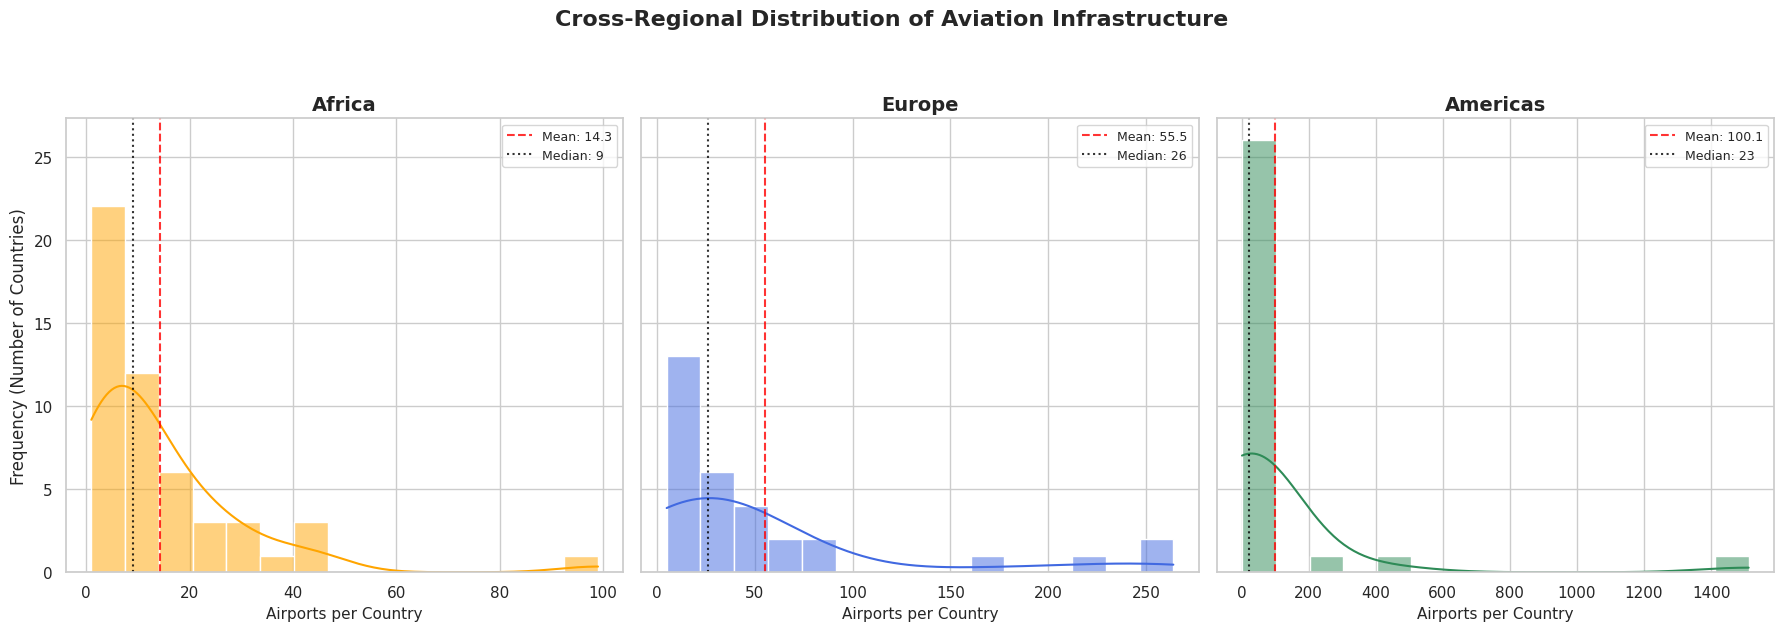

In [ ]:
sns.set_theme(style="whitegrid", palette="muted")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
regions = [
    (airports_per_country_africa, "Africa", "orange"),
    (airports_per_country_europe, "Europe", "royalblue"),
    (airports_per_country_america, "Americas", "seagreen")
]

for ax, (data, title, color) in zip(axes, regions):
    sns.histplot(data, bins=15, kde=True, ax=ax, color=color, alpha=0.5, edgecolor='white')

    mean_val = data.mean()
    median_val = data.median()
    ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.1f}')
    ax.axvline(median_val, color='black', linestyle=':', alpha=0.8, label=f'Median: {median_val:.0f}')

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Airports per Country", fontsize=11)
    ax.legend(fontsize=9)

axes[0].set_ylabel("Frequency (Number of Countries)", fontsize=12)
plt.suptitle("Cross-Regional Distribution of Aviation Infrastructure", fontsize=16, fontweight='bold', y=1.05)

plt.tight_layout()
plt.show()

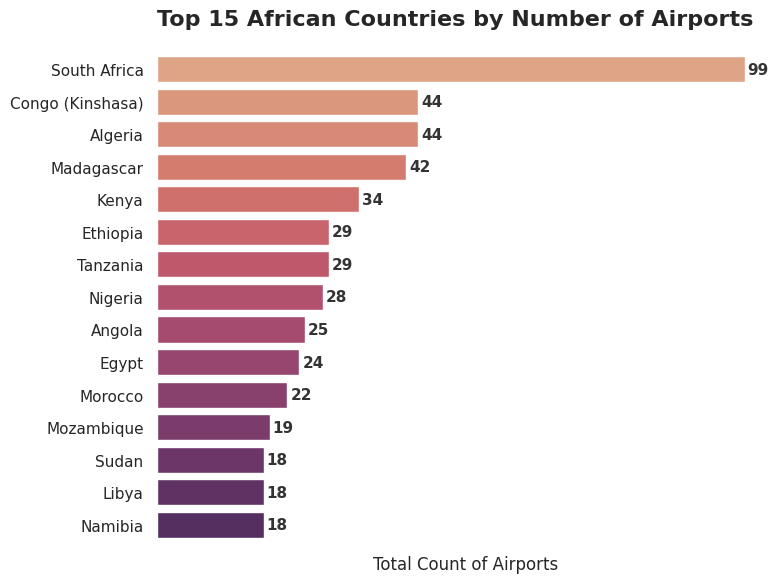

In [ ]:
top_countries = african_airports["country"].value_counts().head(15)

sns.set_theme(style="white")
plt.figure(figsize=(8, 6))

ax = sns.barplot(
    x=top_countries.values,
    y=top_countries.index,
    palette="flare",
    hue=top_countries.index,
    legend=False
)

for i, value in enumerate(top_countries.values):
    ax.text(
        value + 0.5, i, f'{int(value)}',
        va='center', fontsize=11, fontweight='bold', color='#333333'
    )

plt.title("Top 15 African Countries by Number of Airports", fontsize=16, pad=20, fontweight='bold', loc='left')
plt.xlabel("Total Count of Airports", fontsize=12, labelpad=10)
plt.ylabel("", fontsize=12)

sns.despine(left=True, bottom=True)
plt.xticks([])
plt.tight_layout()

plt.show()

### **Routes**

In [ ]:
routes = routes[
    (routes["source_airport"] != "\\N") &
    (routes["destination_airport"] != "\\N")
]

routes["source_airport_id"] = pd.to_numeric(
    routes["source_airport_id"], errors="coerce"
)
routes["destination_airport_id"] = pd.to_numeric(
    routes["destination_airport_id"], errors="coerce"
)

In [ ]:
african_routes = routes[
    (routes["source_airport"].isin(african_iata)) &
    (routes["destination_airport"].isin(african_iata))
].copy()

print("African routes :", african_routes.shape[0])

African routes : 1928


In [ ]:
african_routes.head()

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment
83,2J,470,ACC,248.0,OUA,246.0,NaN,0,CRJ
85,2J,470,BKO,1044.0,DKR,1084.0,NaN,0,M87
86,2J,470,BKO,1044.0,OUA,246.0,NaN,0,CRJ
88,2J,470,BOY,247.0,OUA,246.0,NaN,0,CRJ
89,2J,470,COO,245.0,LFW,298.0,NaN,0,M87


# **Merging data to construct Africa network**

In [ ]:
african_routes = african_routes.merge(
    african_airports[[
        "iata", "latitude", "longitude", "country", "city"
    ]],
    left_on="source_airport",
    right_on="iata",
    how="inner"
).rename(columns={
    "latitude": "source_lat",
    "longitude": "source_lon",
    "country": "source_country",
    "city": "source_city"
}).drop(columns=["iata"])

In [ ]:
african_routes = african_routes.merge(
    african_airports[[
        "iata", "latitude", "longitude", "country", "city"
    ]],
    left_on="destination_airport",
    right_on="iata",
    how="inner"
).rename(columns={
    "latitude": "dest_lat",
    "longitude": "dest_lon",
    "country": "dest_country",
    "city": "dest_city"
}).drop(columns=["iata"])

In [ ]:
african_routes.head()

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment,source_lat,source_lon,source_country,source_city,dest_lat,dest_lon,dest_country,dest_city
0,2J,470,ACC,248.0,OUA,246.0,NaN,0,CRJ,5.60519,-0.166786,Ghana,Accra,12.35320,-1.51242,Burkina Faso,Ouagadougou
1,2J,470,BKO,1044.0,DKR,1084.0,NaN,0,M87,12.53350,-7.949940,Mali,Bamako,14.73970,-17.49020,Senegal,Dakar
2,2J,470,BKO,1044.0,OUA,246.0,NaN,0,CRJ,12.53350,-7.949940,Mali,Bamako,12.35320,-1.51242,Burkina Faso,Ouagadougou
3,2J,470,BOY,247.0,OUA,246.0,NaN,0,CRJ,11.16010,-4.330970,Burkina Faso,Bobo-dioulasso,12.35320,-1.51242,Burkina Faso,Ouagadougou
4,2J,470,COO,245.0,LFW,298.0,NaN,0,M87,6.35723,2.384350,Benin,Cotonou,6.16561,1.25451,Togo,Lome


In [ ]:
print("African airports:", african_airports.shape[0])

African airports: 727


# **Africa network**


Requirements
*   Geographic coordinates
*   Effective formula to compute distance:
    - Choice: Haversine formula



## ***Haversine Formula***

The Haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.1. The mathematical representation given two points $P_1(\phi_1, \lambda_1)$ and $P_2(\phi_2, \lambda_2)$, where $\phi$ is latitude and $\lambda$ is longitude (in radians):

$$a = \sin^2\left(\frac{\Delta\phi}{2}\right) + \cos(\phi_1) \cdot \cos(\phi_2) \cdot \sin^2\left(\frac{\Delta\lambda}{2}\right)$$

$$c = 2 \cdot \operatorname{atan2}\left(\sqrt{a}, \sqrt{1-a}\right)$$

$$d = R \cdot c$$

Where:
- $\Delta\phi = \phi_2 - \phi_1$ (Difference in latitude)
- $\Delta\lambda = \lambda_2 - \lambda_1$ (Difference in longitude)$R$ is the Earth's radius (mean radius $\approx 6,371$ km)
- $d$ is the distance between the two points

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c


In [ ]:
african_routes["distance_km"] = haversine(
    african_routes["source_lat"],
    african_routes["source_lon"],
    african_routes["dest_lat"],
    african_routes["dest_lon"]
)

In [ ]:
african_routes["distance_km"].max()

6716.693576451292

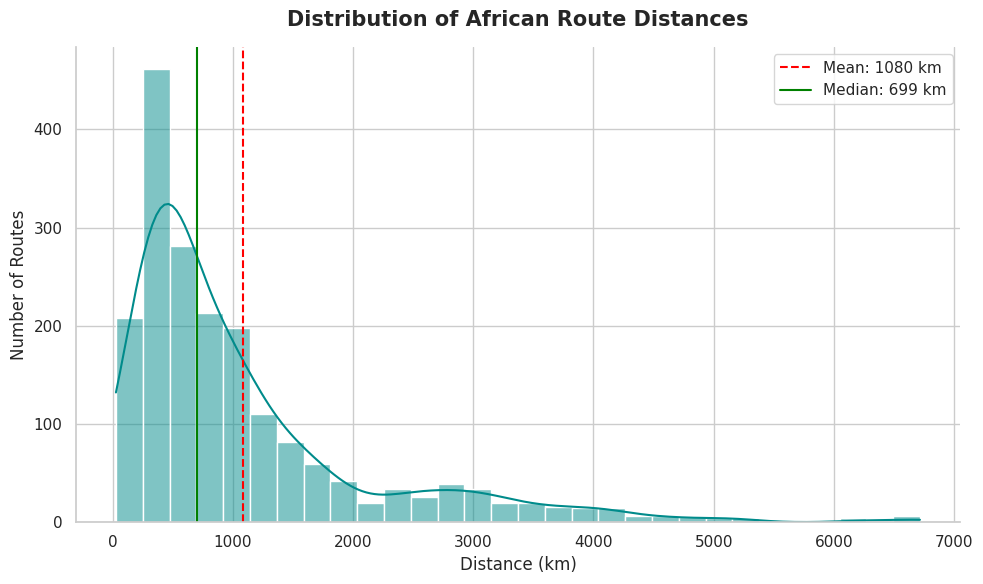

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(african_routes["distance_km"], bins=30, kde=True, color="darkcyan", edgecolor="white")

mean_dist = african_routes["distance_km"].mean()
median_dist = african_routes["distance_km"].median()

plt.axvline(mean_dist, color='red', linestyle='--', label=f'Mean: {mean_dist:.0f} km')
plt.axvline(median_dist, color='green', linestyle='-', label=f'Median: {median_dist:.0f} km')

plt.title("Distribution of African Route Distances", fontsize=15, fontweight='bold', pad=15)
plt.xlabel("Distance (km)", fontsize=12)
plt.ylabel("Number of Routes", fontsize=12)
plt.legend()

sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
G = nx.DiGraph()

for _, row in african_routes.iterrows():

  G.add_edge(
  row["source_airport"],
  row["destination_airport"],
  weight=row["distance_km"]
  )



degrees = dict(G.degree())
max_degree = max(degrees.values()) if degrees else 1

africa_map = folium.Map(
    location=[0, 20],
    zoom_start=4,
    tiles="cartodbpositron"
)

for _, row in african_routes.iterrows():
    weight = 1 if row["distance_km"] > 2000 else 2

    folium.PolyLine(
        locations=[
            (row["source_lat"], row["source_lon"]),
            (row["dest_lat"], row["dest_lon"])
        ],
        color="#2980b9",
        weight=weight,
        opacity=0.3
    ).add_to(africa_map)

for _, row in african_airports.iterrows():
    iata = row['iata']
    importance = (degrees.get(iata, 0) / max_degree) * 10 + 2

    folium.CircleMarker(
        location=(row["latitude"], row["longitude"]),
        radius=importance,
        color="#c0392b",
        fill=True,
        fill_color="#e74c3c",
        fill_opacity=0.7,
        popup=folium.Popup(f"<b>{iata}</b><br>{row['city']}<br>Routes: {degrees.get(iata, 0)}", max_width=200)
    ).add_to(africa_map)

africa_map

# **Additional feature engineering**



In [ ]:
african_routes.head()

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment,source_lat,source_lon,source_country,source_city,dest_lat,dest_lon,dest_country,dest_city,distance_km
0,2J,470,ACC,248.0,OUA,246.0,NaN,0,CRJ,5.60519,-0.166786,Ghana,Accra,12.35320,-1.51242,Burkina Faso,Ouagadougou,764.743592
1,2J,470,BKO,1044.0,DKR,1084.0,NaN,0,M87,12.53350,-7.949940,Mali,Bamako,14.73970,-17.49020,Senegal,Dakar,1059.572897
2,2J,470,BKO,1044.0,OUA,246.0,NaN,0,CRJ,12.53350,-7.949940,Mali,Bamako,12.35320,-1.51242,Burkina Faso,Ouagadougou,699.274661
3,2J,470,BOY,247.0,OUA,246.0,NaN,0,CRJ,11.16010,-4.330970,Burkina Faso,Bobo-dioulasso,12.35320,-1.51242,Burkina Faso,Ouagadougou,334.279425
4,2J,470,COO,245.0,LFW,298.0,NaN,0,M87,6.35723,2.384350,Benin,Cotonou,6.16561,1.25451,Togo,Lome,126.687600


### **Let's add a normalization function minmax for further use.**

The Min-Max FormulaFor a given feature $x$, the normalized value $x_{norm}$ is calculated as follows:

$$x_{norm} = \frac{x - \min(X)}{\max(X) - \min(X)}$$

Where:

- $x$: The original value you want to scale.

- $\min(X)$: The minimum value in the dataset.

- $\max(X)$: The maximum value in the dataset.

- $x_{norm}$: The resulting value, strictly between $0$ and $1$.

In [ ]:
def minmax(series):
    return (series - series.min()) / (series.max() - series.min())

## **Degree of connectivity of airport and of the route**

The connectivity variable quantifies the "strategic weight" of a specific route by summing the number of existing connections at both the origin and the destination airports.

For a route $R$ connecting airport $A$ (source) to airport $B$ (destination), the connectivity is calculated as follows:

- **Source Out-Degree ($k_{out, A}$)**: The total number of flights departing from airport $A$.

- **Destination In-Degree ($k_{in, B}$)**: The total number of flights arriving at airport $B$.

- **Raw Connectivity**: $C_{raw} = k_{out, A} + k_{in, B}$

- **Normalized Connectivity**:

$$C_{norm} = \frac{C_{raw} - \min(C)}{\max(C) - \min(C)}$$

In [ ]:
out_degree = african_routes["source_airport"].value_counts()
african_routes["source_out_degree"] = african_routes["source_airport"].map(out_degree)
in_degree = african_routes["destination_airport"].value_counts()
african_routes["destination_in_degree"] = african_routes["destination_airport"].map(out_degree)
african_routes["destination_in_degree"] = african_routes["destination_in_degree"].fillna(0)
african_routes['connectivity'] = african_routes['source_out_degree'] + african_routes['destination_in_degree']
african_routes['connectivity'] = minmax(african_routes['connectivity'])

## **PageRank variable**

Originally designed by Google's founders to rank web pages, PageRank in this context measures the prestige and relative importance of an airport based on the global structure of the African flight network.

PageRank works by "passing" importance from one node to another. An airport's score depends not just on how many connections it has (degree), but on the quality of those connections.The formula for the PageRank of an airport $u$ is:

$$PR(u) = \frac{1-d}{N} + d \sum_{v \in B_u} \frac{PR(v)}{L(v)}$$

Where:

- $d$: The damping factor set to $0.85$ (0.85 as suggested by Brin and Page, 1999), representing the probability that a "random traveler" continues their journey along the network rather than starting fresh.

- $B_u$: The set of airports that have incoming flights to airport $u$.

- $L(v)$: The number of outgoing flights from airport $v$.

- $N$: The total number of airports in the network.

In [ ]:
G = nx.DiGraph()

for _, row in african_routes.iterrows():
    G.add_edge(
        row["source_airport"],
        row["destination_airport"],
        weight=row["distance_km"]
    )

pagerank = nx.pagerank(G, alpha=0.85)
african_routes["source_pagerank"] = african_routes["source_airport"].map(pagerank).fillna(0)
african_routes["dest_pagerank"] = african_routes["destination_airport"].map(pagerank).fillna(0)

## **Definition of the "International" Variable**

This variable identifies whether a route connects two different countries or remains within the borders of a single nation.1. Logic and CalculationThe variable is created using a logical comparison between the origin and destination countries:

- Domestic Route (0): If source_country is equal to dest_country.

- International Route (1): If source_country is not equal to dest_country.

Mathematically, it can be represented as:$$\text{international} =
\begin{cases}
1 & \text{if } \text{Country}_{\text{source}} \neq \text{Country}_{\text{dest}} \\
0 & \text{if } \text{Country}_{\text{source}} = \text{Country}_{\text{dest}}
\end{cases}$$

In [ ]:
african_routes["international"] = (
    african_routes["source_country"] != african_routes["dest_country"]
).astype(int)

In [ ]:
african_routes

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment,source_lat,...,dest_lon,dest_country,dest_city,distance_km,source_out_degree,destination_in_degree,connectivity,source_pagerank,dest_pagerank,international
0,2J,470,ACC,248.0,OUA,246.0,NaN,0,CRJ,5.60519,...,-1.512420,Burkina Faso,Ouagadougou,764.743592,35,20.0,0.279793,0.016931,0.009903,1
1,2J,470,BKO,1044.0,DKR,1084.0,NaN,0,M87,12.53350,...,-17.490200,Senegal,Dakar,1059.572897,22,38.0,0.305699,0.013354,0.016411,1
2,2J,470,BKO,1044.0,OUA,246.0,NaN,0,CRJ,12.53350,...,-1.512420,Burkina Faso,Ouagadougou,699.274661,22,20.0,0.212435,0.013354,0.009903,1
3,2J,470,BOY,247.0,OUA,246.0,NaN,0,CRJ,11.16010,...,-1.512420,Burkina Faso,Ouagadougou,334.279425,1,20.0,0.103627,0.000693,0.009903,0
4,2J,470,COO,245.0,LFW,298.0,NaN,0,M87,6.35723,...,1.254510,Togo,Lome,126.687600,32,13.0,0.227979,0.009900,0.006977,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,XU,\N,NBO,4059.0,EBB,1187.0,NaN,0,M82,-1.31924,...,32.443501,Uganda,Entebbe,521.070285,87,21.0,0.554404,0.043494,0.008315,1
1924,XU,\N,NBO,4059.0,GLK,5688.0,NaN,0,EM2,-1.31924,...,47.454700,Somalia,Galcaio,1475.121140,87,4.0,0.466321,0.043494,0.002360,1
1925,XU,\N,NBO,4059.0,HGA,1121.0,NaN,0,EM2,-1.31924,...,44.088799,Somalia,Hargeisa,1442.590267,87,7.0,0.481865,0.043494,0.003807,1
1926,XU,\N,NBO,4059.0,MGQ,5687.0,NaN,0,M82 DC9,-1.31924,...,45.304699,Somalia,Mogadishu,1002.380653,87,10.0,0.497409,0.043494,0.005768,1


## **Estimation of the frequency of flights**

We use the Gravity Model. The model is based on the principle that the flow between two locations is proportional to their "mass" (importance) and inversely proportional to the distance between them.

For each route between airport $i$ and airport $j$, the estimated frequency is:

$$\hat{f}_{ij} = K \cdot \frac{PR_i \times PR_j}{D_{eff}^\gamma}$$

Where:

- $PR_i, PR_j$: The PageRank of the source and destination (representing the "mass" or attractiveness).

- $D_{eff}$: The effective distance. We used .clip() to implement a penalty for very short distances, preventing the frequency from exploding toward infinity when distance is near zero.

- $\gamma$ (Gamma): The distance decay parameter. A higher $\gamma$ means distance has a stronger negative impact on flight frequency.

- $K$: A normalization constant that scales the relative scores to match the actual total number of flights ($F_{total}$).

In [ ]:
gamma_values = np.linspace(0.01, 2, 100)
F_total = 3584 ## Mean: https://arxiv.org/pdf/2512.02075

for gamma in gamma_values:
    S = np.sum(
        (african_routes["source_pagerank"] * african_routes["dest_pagerank"]) / (african_routes["distance_km"] ** gamma)
    )

    K = F_total / S
    african_routes["D_eff"] = african_routes["distance_km"].clip(lower=african_routes['distance_km'].quantile(0.25))

    african_routes["F_hat"] = K * (
        african_routes["source_pagerank"] * african_routes["dest_pagerank"]
    ) / (african_routes["D_eff"] ** gamma)


    if abs(F_total - african_routes["F_hat"].sum()) <= 10:
      print(african_routes["F_hat"].sum(), "K:", K, "gamma:", gamma)
      break

african_routes["F_hat"].sum()

3582.8755161180525 K: 11758.042433425604 gamma: 0.01


np.float64(3582.8755161180525)

In [ ]:
african_routes.sort_values(by="F_hat", ascending=False).head().iloc[:,:15]

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment,source_lat,source_lon,source_country,source_city,dest_lat,dest_lon
606,ET,2220,ADD,1107.0,JNB,813.0,NaN,0,77L,8.97789,38.799301,Ethiopia,Addis Ababa,-26.13920,28.246000
1452,SA,4305,JNB,813.0,ADD,1107.0,Y,0,77L,-26.13920,28.246000,South Africa,Johannesburg,8.97789,38.799301
691,ET,2220,JNB,813.0,ADD,1107.0,NaN,0,77L,-26.13920,28.246000,South Africa,Johannesburg,8.97789,38.799301
1393,SA,4305,ADD,1107.0,JNB,813.0,Y,0,77L,8.97789,38.799301,Ethiopia,Addis Ababa,-26.13920,28.246000
924,KQ,3126,JNB,813.0,NBO,4059.0,NaN,0,738 763 73W,-26.13920,28.246000,South Africa,Johannesburg,-1.31924,36.927799


## Synthetic Demand Modeling

We utilize a demand proxy ($D_{ij}$) based on a modified Gravity Model with exponential decay. This formulation captures the interaction between airport importance and the physical distance separating them.1. The Mathematical FormulationWe define the demand for a route between airport $i$ and airport $j$ as:

$$D_{ij} = \alpha \cdot (C_i \cdot C_j) \cdot e^{-\beta \cdot d_{ij}}$$


Where:

- $C_i, C_j$ (Connectivity Scores): These are the importance metrics for the origin and destination airports. We use scores such as Degree Centrality or PageRank to represent the "attractiveness" of the nodes.

- $d_{ij}$ (Distance): The great-circle distance (calculated via the Haversine formula) between the two airports.

- $\alpha$ (Scaling Factor): A calibration parameter used to scale the synthetic scores into realistic demand magnitudes.

- $\beta$ (Decay Constant): The parameter controlling how quickly demand drops as distance increases. A higher $\beta$ implies that travelers are much less likely to fly long distances.

In [ ]:
african_routes["source_pagerank_norm"] = minmax(african_routes["source_pagerank"])
african_routes["dest_pagerank_norm"] = minmax(african_routes["dest_pagerank"])

In [ ]:
alpha = 1
beta = 0.0001

Our Logic

We first calculate the demand_raw using the gravity potential. However, since this value is derived from normalized PageRank scores, its sum does not reflect actual flight frequencies. By setting:

$$\alpha = \frac{F_{total}}{\sum \text{demand_raw}}$$

We anchor the entire network to the empirical total ($F_{total} = 3584$). This transformation converts a dimensionless probability into a physical flow estimate.

In [ ]:
african_routes['demand_raw'] = alpha * african_routes['source_pagerank_norm'] * african_routes['dest_pagerank_norm'] * np.exp(-beta * african_routes['distance_km'])

In [ ]:
alpha = F_total / african_routes["demand_raw"].sum()
african_routes["demand"] = alpha * african_routes["demand_raw"]


In [ ]:
african_routes.sort_values(by="demand", ascending=False)['demand']

,demand
737,28.888524
871,28.888524
1281,28.888524
950,28.888524
846,28.886215
...,...
505,0.000124
316,0.000000
804,0.000000
1768,0.000000


## The Revenue Equation

We calculate the total revenue for a route ($R_{ij}$) using the following formulation:

$$R_{ij} = \rho \cdot D_{ij} \cdot f_{ij}$$

Where
- $D_{ij}$ (Demand): The latent passenger volume or "market attractiveness" derived from our calibrated Gravity Model.

- $f_{ij}$ (Frequency): The number of scheduled flights operated on the route. This represents the capacity provided to meet the demand.

- $p$ (Average Revenue-per-Passenger): The yield coefficient. It represents the mean financial gain per passenger, capturing the pricing power on that specific segment.

In [ ]:
rho = 200

In [ ]:
african_routes['revenue'] = rho * african_routes['demand'] * african_routes['F_hat']

In [ ]:
african_routes.sort_values(by="revenue", ascending=False)['revenue']

,revenue
606,164849.216855
1393,164849.216855
691,164844.577225
1452,164844.577225
871,141025.646533
...,...
505,0.000113
316,0.000000
804,0.000000
1768,0.000000


## **The Operating Cost Model**

We define the cost of operating a route between airport $i$ and airport $j$ using a linear cost function:

$$C_{ij} = c_f \cdot d_{ij} + c_a$$

Where
- $c_f$ (Variable Cost per km): This represents the fuel, maintenance, and crew costs. Since fuel consumption is directly proportional to the time spent in the air, this cost scales linearly with the distance ($d_{ij}$).

- $d_{ij}$ (Distance): The actual flight distance in kilometers.

- $c_a$ (Fixed Operational Cost): This covers airport landing fees, ground handling, and navigation charges. These costs are "fixed" per segment because they are incurred regardless of whether the flight is 100km or 1,000km.

In [ ]:
african_routes.merge(estimated_seats, left_on='source_airport', right_on='iata_code', how='inner')

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment,source_lat,...,source_pagerank_norm,dest_pagerank_norm,demand_raw,demand,revenue,iata_code,icao_code,manufacturer_and_aircraft_type_model,wtc,Seats_Estimated
0,JE,3393,GRJ,804.0,JNB,813.0,NaN,0,738 733,-34.005600,...,0.021118,1.000000,0.019031,0.830576,167.212666,GRJ,NaN,Gulfstream Aerospace G-1159 Gulfstream II / II...,M,NaN
1,MN,1829,GRJ,804.0,JNB,813.0,NaN,0,738,-34.005600,...,0.021118,1.000000,0.019031,0.830576,167.212666,GRJ,NaN,Gulfstream Aerospace G-1159 Gulfstream II / II...,M,NaN
2,SA,4305,GRJ,804.0,CPT,797.0,Y,0,CR2 ER3 AR8,-34.005600,...,0.021118,0.264876,0.005402,0.235769,13.052587,GRJ,NaN,Gulfstream Aerospace G-1159 Gulfstream II / II...,M,NaN
3,SA,4305,GRJ,804.0,DUR,799.0,Y,0,ER3,-34.005600,...,0.021118,0.113721,0.002182,0.095228,2.356000,GRJ,NaN,Gulfstream Aerospace G-1159 Gulfstream II / II...,M,NaN
4,SA,4305,GRJ,804.0,JNB,813.0,NaN,0,738 733,-34.005600,...,0.021118,1.000000,0.019031,0.830576,167.212666,GRJ,NaN,Gulfstream Aerospace G-1159 Gulfstream II / II...,M,NaN
5,W3,20976,ABB,NaN,ABV,260.0,NaN,0,73G,6.204167,...,0.006369,0.213772,0.001319,0.057557,1.361665,ABB,A3ST,Airbus Industrie A300-600ST Beluga Freighter,H,NaN
6,W3,20976,ABB,NaN,LOS,273.0,NaN,0,73G,6.204167,...,0.006369,0.339075,0.002081,0.090808,3.349459,ABB,A3ST,Airbus Industrie A300-600ST Beluga Freighter,H,NaN
7,W3,20976,BNI,262.0,ABV,260.0,NaN,0,CR9 73G,6.316980,...,0.005824,0.213772,0.001202,0.052464,1.199661,BNI,BN2P,Pilatus Britten-Norman BN-2A/B Islander,L,NaN
8,W3,20976,BNI,262.0,LOS,273.0,NaN,0,73G,6.316980,...,0.005824,0.339075,0.001925,0.084030,2.995777,BNI,BN2P,Pilatus Britten-Norman BN-2A/B Islander,L,NaN


In [ ]:
african_routes['hub'] = african_routes['source_pagerank'] + african_routes['dest_pagerank']

african_routes['hub'] = minmax(african_routes['hub'])

In [ ]:
african_routes['equipment'] = african_routes['equipment'].fillna('Unknown').astype(str)

african_routes['equipment'] = african_routes['equipment'].str.split(' ')

african_routes_per_equipment = african_routes.explode('equipment')

african_routes_per_equipment['equipment'] = african_routes_per_equipment['equipment'].str.strip("{}")

In [ ]:
african_routes_per_equipment['equipment'] = (
    african_routes_per_equipment['equipment']
    .astype(str)
    .str.replace(r"[\[\]'\" ]", "", regex=True)
)

african_routes_per_equipment['equipment'] = african_routes_per_equipment['equipment'].str.split(',')

african_routes_per_equipment = african_routes_per_equipment.explode('equipment')

african_routes_per_equipment = african_routes_per_equipment[african_routes_per_equipment['equipment'] != ""]

In [ ]:
african_routes_per_equipment = african_routes_per_equipment.merge(estimated_seats, left_on='equipment', right_on='iata_code', how='left')

In [ ]:
african_routes_per_equipment.dropna(subset=['source_airport_id', 'destination_airport_id'], inplace=True)

In [ ]:
median_value = african_routes_per_equipment['Seats_Estimated'].median()

african_routes_per_equipment['Seats_Estimated'] = african_routes_per_equipment['Seats_Estimated'].fillna(median_value)

In [ ]:
def calculate_route_cost(row):
    ca = 624.892

    air_craft = str(row['equipment'])
    distance_km = row['distance_km']
    seat_mean = estimated_seats["Seats_Estimated"].mean()

    try:
        mask = estimated_seats['iata_code'].str.contains(air_craft, na=False)
        seats = int(estimated_seats.loc[mask, "Seats_Estimated"].iloc[0])

        fuel_used_cost = (0.020 * distance_km * seats * 1.1) + ca
        return fuel_used_cost
    except:
        return (0.020 * distance_km * seat_mean * 1.1) + ca

african_routes_per_equipment['cost'] = african_routes_per_equipment.apply(calculate_route_cost, axis=1)

## Energy consumption estimation


Knot is the unit of speed used in aviation
1 knot = 1.15 miles per hour (statute miles per hour)

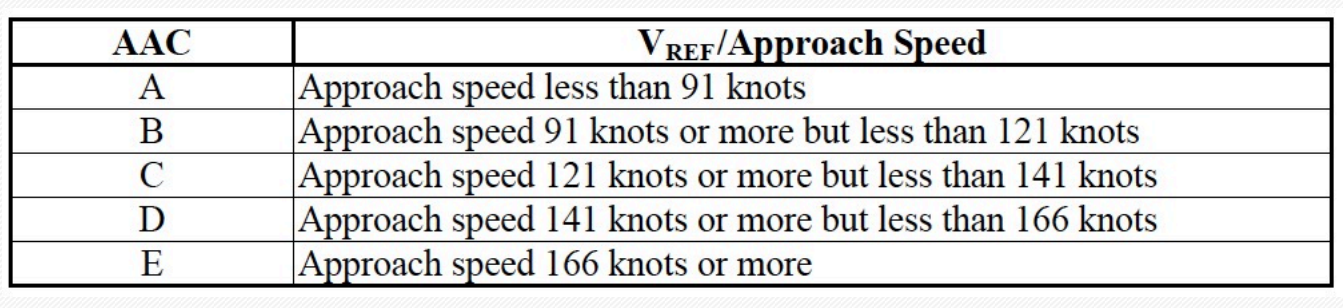

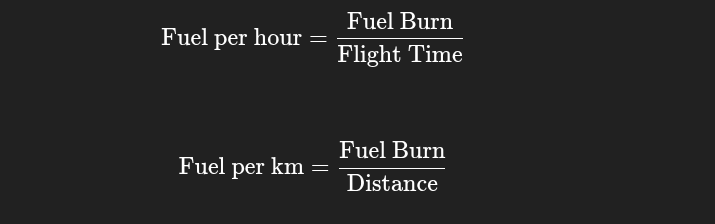


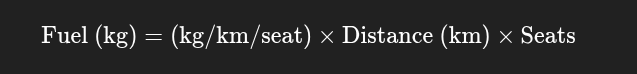


# kg fuel / km /seat = ~0,02 à 0,025 kg/km/seat

https://reposit.haw-hamburg.de/bitstream/20.500.12738/14232/1/AERO_POS_DLRK2023_FuelConsumption_2023-09-19.pdf

# Fuel cost by equipement

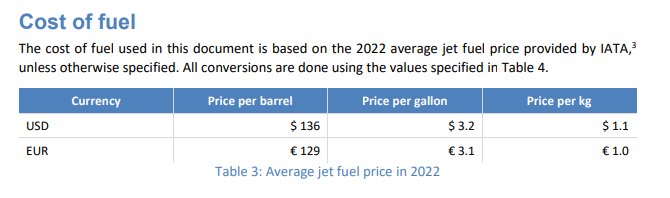

# Cost modeling function

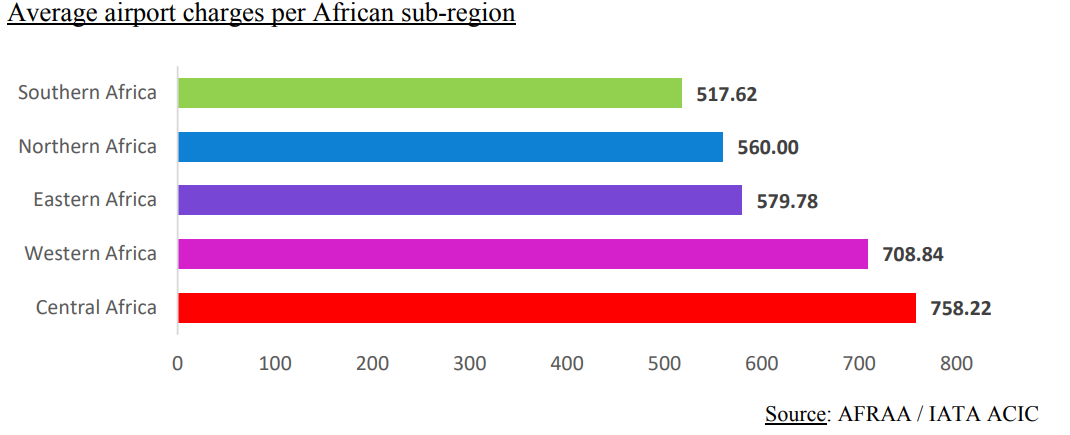

In [ ]:
def calculate_route_cost(row):

    FIXED_COST = 624.892
    FUEL_COST_PER_KM_SEAT = 0.020

    MARKUP_FACTOR = 1.1

    aircraft_code = str(row['equipment'])
    distance_km = row['distance_km']

    seat_mean = estimated_seats["Seats_Estimated"].mean()

    try:
        mask = estimated_seats['iata_code'].str.contains(aircraft_code, na=False)
        seats = int(estimated_seats.loc[mask, "Seats_Estimated"].iloc[0])

        fuel_cost = (FUEL_COST_PER_KM_SEAT * distance_km * seats * MARKUP_FACTOR)
        total_cost = fuel_cost + FIXED_COST

        return total_cost

    except (IndexError, ValueError):
        # If aircraft not found, use average number of seats
        fuel_cost = (FUEL_COST_PER_KM_SEAT * distance_km * seat_mean * MARKUP_FACTOR)
        total_cost = fuel_cost + FIXED_COST

        return total_cost

In [ ]:
african_routes_per_equipment['cost'] = african_routes_per_equipment.apply(calculate_route_cost, axis=1)

The Strategic Objective FunctionWe define our goal as the simultaneous maximization of profitability and network structural integrity:

$$\max \left[ \sum_{i,j} \text{Profit}_{ij} + \gamma \sum_{i,j} \text{Connectivity}_{ij} \right]$$

Where

- $\sum \text{Profit}_{ij}$ (Economic Sustainability): This ensures the network is commercially viable. It prioritizes routes where the revenue ($p \cdot D_{ij} \cdot \rho_{ij}$) exceeds the operational costs ($c_f \cdot d_{ij} + c_a$).

- $\sum \text{Connectivity}_{ij}$ (Strategic Development): This represents the "Social Value" of the network. It prioritizes routes that link underserved regions or strengthen major hubs, even if their immediate profit margin is thin.

- $\gamma$ (The Strategic Weight): This is the most critical parameter. It represents the Policy Lever:If $\gamma$ is low, the model behaves like a private airline focused solely on profit.If $\gamma$ is high, the model behaves like a Pan-African development agency.

In [ ]:
prob = pulp.LpProblem("African_Route_Optimization", pulp.LpMaximize)
routes_idx = african_routes_per_equipment.index

# Variables
x = pulp.LpVariable.dicts("route_active", routes_idx, cat='Binary')
freq = pulp.LpVariable.dicts("frequency", routes_idx, lowBound=0, upBound=100, cat='Integer')

# Big M : maximum flights
M = 30

for i in routes_idx:
    prob += freq[i] <= M * x[i]

    prob += freq[i] >= x[i]

# Objective
hub_weight = 1000

prob += pulp.lpSum([
    # Profit
    (african_routes_per_equipment.loc[i, 'revenue'] * freq[i]) -
    (african_routes_per_equipment.loc[i, 'cost'] * freq[i]) +

    # Connectivity
    (500 * african_routes_per_equipment.loc[i, 'connectivity'] * x[i]) +
    (hub_weight * african_routes_per_equipment.loc[i, 'hub'] * x[i])

    for i in routes_idx
])

total_opened = pulp.lpSum([x[i] for i in routes_idx])
total_hub_score = pulp.lpSum([african_routes_per_equipment.loc[i, 'hub'] * x[i] for i in routes_idx])

# Constraint
prob += total_hub_score >= 0.4 * total_opened

status = prob.solve()
print(f"Status: {pulp.LpStatus[status]}")

if status == pulp.LpStatusOptimal:
    print("Optimal solution found!")

Status: Optimal
Optimal solution found!


In [ ]:
results = []

for i in routes_idx:
    is_active = pulp.value(x[i])
    flights_count = pulp.value(freq[i])

    if is_active:
        results.append({
            'Source': african_routes_per_equipment.loc[i, 'source_city'],
            'Destination': african_routes_per_equipment.loc[i, 'dest_city'],
            'Equipment': african_routes_per_equipment.loc[i, 'equipment'],
            'Frequency_Per_Week': flights_count,
            'Distance_KM': african_routes_per_equipment.loc[i, 'distance_km'],
            'Revenue_Estimated': african_routes_per_equipment.loc[i, 'revenue'] * flights_count,
            'Connectivity_Score': african_routes_per_equipment.loc[i, 'connectivity']
        })


df_plan_de_vol = pd.DataFrame(results)


print(f"Number of operated routes : {len(df_plan_de_vol)}")
print(f"Profit : {pulp.value(prob.objective):,.2f} USD")
print("-" * 30)
df_plan_de_vol.sort_values(by='Frequency_Per_Week', ascending=False).head(20)

Number of operated routes : 425
Profit : 165,902,289.76 USD
------------------------------


,Source,Destination,Equipment,Frequency_Per_Week,Distance_KM,Revenue_Estimated,Connectivity_Score
9,Cairo,Algier,736,30.0,2705.729529,363653.024200,0.398964
424,Wajir,Nairobi,EM2,30.0,488.812246,35363.788962,0.471503
0,Accra,Lagos,319,30.0,400.511356,91577.448547,0.373057
1,Lagos,Accra,319,30.0,400.511356,91563.956545,0.373057
10,Casablanca,Algier,736,30.0,1050.208337,795197.829954,0.393782
11,Casablanca,Oran,736,30.0,685.949904,65142.012316,0.269430
4,Nairobi,Kigali,E70,30.0,757.956774,117653.925296,0.637306
411,Cotonou,Lagos,73G,30.0,106.360669,31491.706653,0.357513
413,Lagos,Accra,73G,30.0,400.511356,91563.956545,0.373057
414,Lagos,Accra,738,30.0,400.511356,91563.956545,0.373057
